In [1]:
# Install and import deps, then lazily open a small ARCO-ERA5 subset (NY bounding box)
!pip -q install -U "xarray[io]" "zarr>=3" numcodecs gcsfs fsspec dask

import numpy as np
import pandas as pd
import dask
import xarray as xr
import gcsfs

xr.set_options(keep_attrs=True)
dask.config.set({"array.slicing.split_large_chunks": True})

ARCO_ERA5_ZARR = "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/"

# Anonymous GCS access
fs = gcsfs.GCSFileSystem(token="anon")
mapper = fs.get_mapper(ARCO_ERA5_ZARR)

print("xarray:", xr.__version__)
print("available engines:", list(xr.backends.list_engines().keys()))

# Open with zarr engine if available; otherwise fall back to generic store engine.
engine = "zarr" if "zarr" in xr.backends.list_engines() else "store"

# Lazily open dataset; chunk on time to keep memory bounded
# NOTE: variable names in ARCO-ERA5 are typically short (e.g., 't2m', 'tp'). We'll inspect and then select.
ds = xr.open_dataset(mapper, engine=engine, consolidated=False, chunks={"time": 24 * 30})

print("Opened dataset.")
print("data_vars (first 30):", list(ds.data_vars)[:30])
print("coords:", list(ds.coords))

# Select NY bounding box (handle longitude conventions)
# ERA5 commonly uses lon in [0, 360). Convert selection accordingly.
lon = ds["longitude"] if "longitude" in ds.coords else ds["lon"]
lat = ds["latitude"] if "latitude" in ds.coords else ds["lat"]

lon_name = lon.name
lat_name = lat.name

lon_vals = lon.values
uses_360 = np.nanmin(lon_vals) >= 0 and np.nanmax(lon_vals) > 180

if uses_360:
    lon_slice = slice(360 - 80, 360 - 71)  # 280..289
else:
    lon_slice = slice(-80, -71)

# latitude is often descending in ERA5
lat_slice = slice(45, 40) if lat.values[0] > lat.values[-1] else slice(40, 45)

ny = ds.sel({lat_name: lat_slice, lon_name: lon_slice})

print("NY subset sizes:")
for k, v in ny.sizes.items():
    print(f"  {k}: {v}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.1 MB/s eta 0:00:0000:010:01
xarray: 2026.2.0
available engines: ['netcdf4', 'h5netcdf', 'scipy', 'kerchunk', 'pydap', 'store', 'zarr']
Opened dataset.
data_vars (first 30): ['100m_u_component_of_wind', '10m_wind_gust_since_previous_post_processing', '10m_v_component_of_wind', '10m_u_component_of_neutral_wind', '100m_v_component_of_wind', '2m_temperature', '2m_dewpoint_temperature', 'air_density_over_the_oceans', 'angle_of_sub_gridscale_orography', '10m_u_component_of_wind', '10m_v_component_of_neutral_wind', 'anisotropy_of_sub_gridscale_orography', 'boundary_layer_height', 'benjamin_feir_index', 'convective_inhibition', 'boundary_layer_dissipation', 'convective_available_potential_energy', 'cloud_base_height', 'coefficient_of_drag_with_waves', 'clear_sky_direct_solar_radiation_at_surface', 'charnock', 'convective_snowfall_rate_water_equivalent', 'eastward_gravity_wave_surface_stress', 'convective_precipitation', 'convective_rain

In [3]:
# Build a *small* daily NY time series first (for fast iteration), then we can scale up
import numpy as np
import pandas as pd
import xarray as xr

# --- 1) Choose variables ---
var_t = "2m_temperature" if "2m_temperature" in ny.data_vars else None
var_tp = "total_precipitation" if "total_precipitation" in ny.data_vars else None

print("Selected variables:", {"temperature": var_t, "precip": var_tp})
if var_t is None or var_tp is None:
    raise KeyError("Missing expected variables; inspect list(ny.data_vars).")

# --- 2) Subset a small time slice for a quick end-to-end test ---
# (Resampling across decades of hourly data can be slow; start small)
ny_small = ny[[var_t, var_tp]].sel(time=slice("2000-01-01", "2002-12-31"))

lat_name = "latitude" if "latitude" in ny_small.coords else "lat"
lon_name = "longitude" if "longitude" in ny_small.coords else "lon"

# --- 3) Simple area mean over the NY box ---
ny_box_mean = ny_small.mean(dim=[lat_name, lon_name], skipna=True)

# --- 4) Convert hourly -> daily ---
# Temperature: daily max (Kelvin -> Celsius)
# Precip: daily sum (ERA5 total_precipitation is typically meters of water)

t2m_daily_max_C = (ny_box_mean[var_t] - 273.15).resample(time="1D").max()

# meters -> mm
# (If units differ, we will detect/adjust later.)
tp_daily_sum_mm = (ny_box_mean[var_tp] * 1000.0).resample(time="1D").sum()

ny_daily_small = xr.Dataset(
    {
        "t2m_daily_max_C": t2m_daily_max_C,
        "tp_daily_sum_mm": tp_daily_sum_mm,
    }
)

print(ny_daily_small)
print("Computing a tiny sample to confirm pipeline...")
print(ny_daily_small.isel(time=slice(0, 5)).compute().to_dataframe())


Selected variables: {'temperature': '2m_temperature', 'precip': 'total_precipitation'}
<xarray.Dataset> Size: 18kB
Dimensions:          (time: 1096)
Coordinates:
  * time             (time) datetime64[ns] 9kB 2000-01-01 ... 2002-12-31
Data variables:
    t2m_daily_max_C  (time) float32 4kB dask.array<chunksize=(1,), meta=np.ndarray>
    tp_daily_sum_mm  (time) float32 4kB dask.array<chunksize=(1,), meta=np.ndarray>
Computing a tiny sample to confirm pipeline...
            t2m_daily_max_C  tp_daily_sum_mm
time                                        
2000-01-01         6.125031         0.060260
2000-01-02         9.231628         1.790532
2000-01-03        10.104462         3.640988
2000-01-04         9.775330        17.663258
2000-01-05         5.209167         4.167274


In [9]:
# Convert a *tiny* slice to pandas to avoid any accidental large compute
# This is a diagnostic cell to confirm the daily dataset converts cleanly.

import numpy as np
import pandas as pd

assert "ny_daily_small" in globals(), "ny_daily_small not found; run Cell 2 first."

# Take a very small time slice (10 days) and compute it
ny_10d = ny_daily_small.isel(time=slice(0, 10)).compute()

pdf_10d = ny_10d.to_dataframe().reset_index()
pdf_10d["doy"] = pdf_10d["time"].dt.dayofyear.astype(np.int16)

print("pdf_10d shape:", pdf_10d.shape)
print("dtypes:\n", pdf_10d.dtypes)
print(pdf_10d)


pdf_10d shape: (10, 4)
dtypes:
 time               datetime64[ns]
t2m_daily_max_C           float32
tp_daily_sum_mm           float32
doy                         int16
dtype: object
        time  t2m_daily_max_C  tp_daily_sum_mm  doy
0 2000-01-01         6.125031         0.060260    1
1 2000-01-02         9.231628         1.790532    2
2 2000-01-03        10.104462         3.640988    3
3 2000-01-04         9.775330        17.663258    4
4 2000-01-05         5.209167         4.167274    5
5 2000-01-06         1.538147         0.023442    6
6 2000-01-07         2.502319         1.104316    7
7 2000-01-08         1.867554         0.088887    8
8 2000-01-09         5.371918         0.508462    9
9 2000-01-10         5.781158        10.986964   10


In [13]:
# Step 1/3: Compute ONLY the local daily target (fast sanity check)
# - Target: local daily max 2m temperature (C) averaged over NY box

import numpy as np
import pandas as pd
import xarray as xr

assert "ny" in globals(), "ny not found; run Cell 1 first."

var_t = "2m_temperature"
lat_name = "latitude" if "latitude" in ny.coords else "lat"
lon_name = "longitude" if "longitude" in ny.coords else "lon"

# Small bounded time window for iteration
ny_slice_t = ny[[var_t]].sel(time=slice("2000-01-01", "2000-03-31"))

# Area-mean over NY box (still lazy)
local_box_t = ny_slice_t.mean(dim=[lat_name, lon_name], skipna=True)

# Daily max temperature (C)
y_local_tmax_C = (local_box_t[var_t] - 273.15).resample(time="1D").max().rename("y_tmax_C")

print("y_local_tmax_C (lazy):", y_local_tmax_C)

# Materialize to pandas (should be quick for ~90 days)
ydf = y_local_tmax_C.compute().to_dataframe().reset_index().dropna().sort_values("time")

print("y df shape:", ydf.shape)
print(ydf.head(10))


y_local_tmax_C (lazy): <xarray.DataArray 'y_tmax_C' (time: 91)> Size: 364B
dask.array<stack, shape=(91,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 728B 2000-01-01 2000-01-02 ... 2000-03-31
Attributes:
    long_name:   2 metre temperature
    short_name:  t2m
    units:       K
y df shape: (91, 2)
        time   y_tmax_C
0 2000-01-01   6.125031
1 2000-01-02   9.231628
2 2000-01-03  10.104462
3 2000-01-04   9.775330
4 2000-01-05   5.209167
5 2000-01-06   1.538147
6 2000-01-07   2.502319
7 2000-01-08   1.867554
8 2000-01-09   5.371918
9 2000-01-10   5.781158


In [15]:
# Step 2/3 (refactored): Coarse-scale daily predictors over the NY box
# - Keep this as a *diagnostic* by computing only 7 days first to avoid long runs.

import time
import numpy as np
import pandas as pd
import xarray as xr

assert "ny" in globals(), "ny not found; run Cell 1 first."

lat_name = "latitude" if "latitude" in ny.coords else "lat"
lon_name = "longitude" if "longitude" in ny.coords else "lon"

var_t = "2m_temperature"
var_tp = "total_precipitation"

# Match the same overall window as Cell 4, but only compute a 7-day sample first
ny_slice_x = ny[[var_t, var_tp]].sel(time=slice("2000-01-01", "2000-01-31"))

# Coarsen: lat=21, lon=37. Use boundary='trim' so factors don't need to divide perfectly.
coarse = ny_slice_x.coarsen({lat_name: 3, lon_name: 3}, boundary="trim").mean()

# Reduce spatially -> single coarse time series
coarse_mean = coarse.mean(dim=[lat_name, lon_name], skipna=True)

# Daily features: temp mean (C) and precip sum (mm)
x_t2m_mean_C = (coarse_mean[var_t] - 273.15).resample(time="1D").mean().rename("x_t2m_mean_C")
x_tp_sum_mm = (coarse_mean[var_tp] * 1000.0).resample(time="1D").sum().rename("x_tp_sum_mm")

x_daily = xr.merge([x_t2m_mean_C, x_tp_sum_mm])

# Compute a tiny slice for sanity
x_daily_7 = x_daily.isel(time=slice(0, 7))

t0 = time.time()
xdf_7 = x_daily_7.compute().to_dataframe().reset_index().dropna().sort_values("time")
print(f"Computed 7 daily rows in {time.time() - t0:.2f}s")
print("xdf_7 shape:", xdf_7.shape)
print(xdf_7)

# NOTE: Once this is fast/stable, we will scale to the full window and then merge with ydf.

Computed 7 daily rows in 16.38s
xdf_7 shape: (7, 3)
        time  x_t2m_mean_C  x_tp_sum_mm
0 2000-01-01      0.146750     0.061710
1 2000-01-02      4.266472     1.809860
2 2000-01-03      8.130673     3.726150
3 2000-01-04      7.520962    17.939342
4 2000-01-05     -1.759453     3.937275
5 2000-01-06     -3.716091     0.023797
6 2000-01-07      0.904489     1.105253


In [18]:
# Assemble an aligned daily modeling table (features X + target y) for a bounded window
# - Compute predictors together to avoid multiple heavy dask graphs

import numpy as np
import pandas as pd

assert "ny" in globals(), "ny not found; run Cell 1 first."
assert "ydf" in globals(), "ydf not found; run Cell 4 first."

lat_name = "latitude" if "latitude" in ny.coords else "lat"
lon_name = "longitude" if "longitude" in ny.coords else "lon"

var_t = "2m_temperature"
var_tp = "total_precipitation"

# Keep the window aligned to ydf; start with a short diagnostic window, then widen later
_full_start = ydf["time"].min()
_full_end = ydf["time"].max()

t_start = _full_start
# 14-day window to keep compute bounded
t_end = min(_full_end, _full_start + pd.Timedelta(days=13))

print('Using window:', t_start, '->', t_end)

ny_slice_x_full = ny[[var_t, var_tp]].sel(time=slice(str(pd.Timestamp(t_start).date()), str(pd.Timestamp(t_end).date())))

# Coarsen then spatially average -> single coarse time series
coarse_full = ny_slice_x_full.coarsen({lat_name: 3, lon_name: 3}, boundary="trim").mean()
coarse_mean_full = coarse_full.mean(dim=[lat_name, lon_name], skipna=True)

# Build daily predictors as one Dataset, then compute once
x_daily_ds = xr.Dataset(
    {
        "x_t2m_mean_C": (coarse_mean_full[var_t] - 273.15).resample(time="1D").mean(),
        "x_tp_sum_mm": (coarse_mean_full[var_tp] * 1000.0).resample(time="1D").sum(),
    }
)

# Compute predictors together (single dask compute)
import time as _time
_t0 = _time.time()
computed_x = x_daily_ds.compute()
print(f"Computed predictors in {_time.time() - _t0:.2f}s")

xdf = (
    computed_x.to_dataframe()
    .reset_index()
    .dropna()
    .sort_values("time")
    .reset_index(drop=True)
)

# Merge with y
model_df = (
    ydf.merge(xdf, on="time", how="inner")
    .dropna()
    .sort_values("time")
    .reset_index(drop=True)
)

# Add simple calendar features (kept minimal + interpretable)
model_df["doy"] = model_df["time"].dt.dayofyear.astype(np.int16)
model_df["month"] = model_df["time"].dt.month.astype(np.int8)

print("model_df shape:", model_df.shape)
print("date range:", model_df["time"].min(), "->", model_df["time"].max())
print(model_df.head(10))
print("Missingness (top):\n", model_df.isna().mean().sort_values(ascending=False).head(10))


Using window: 2000-01-01 00:00:00 -> 2000-01-14 00:00:00
Computed predictors in 15.52s
model_df shape: (14, 6)
date range: 2000-01-01 00:00:00 -> 2000-01-14 00:00:00
        time   y_tmax_C  x_t2m_mean_C  x_tp_sum_mm  doy  month
0 2000-01-01   6.125031      0.146750     0.061710    1      1
1 2000-01-02   9.231628      4.266472     1.809860    2      1
2 2000-01-03  10.104462      8.130673     3.726150    3      1
3 2000-01-04   9.775330      7.520962    17.939342    4      1
4 2000-01-05   5.209167     -1.759453     3.937275    5      1
5 2000-01-06   1.538147     -3.716091     0.023797    6      1
6 2000-01-07   2.502319      0.904489     1.105253    7      1
7 2000-01-08   1.867554     -1.643888     0.088186    8      1
8 2000-01-09   5.371918      2.265177     0.522168    9      1
9 2000-01-10   5.781158      3.590759    11.075420   10      1
Missingness (top):
 time            0.0
y_tmax_C        0.0
x_t2m_mean_C    0.0
x_tp_sum_mm     0.0
doy             0.0
month           0.0
d

In [19]:
# Fit an XGBoost observation-operator model (coarse predictors -> local daily Tmax)
# - Uses a simple time-based train/test split to avoid leakage

import numpy as np
import pandas as pd

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

assert "model_df" in globals(), "model_df not found; run Cell 6 first."

# Features: coarse daily mean temperature + precip + calendar
feature_cols = ["x_t2m_mean_C", "x_tp_sum_mm", "doy", "month"]
target_col = "y_tmax_C"

# Ensure sorted and clean
_df = model_df.dropna(subset=feature_cols + [target_col]).sort_values("time").reset_index(drop=True)

# Time-based split (first 70% train, last 30% test)
split_idx = int(len(_df) * 0.7)
train_df = _df.iloc[:split_idx].copy()
test_df = _df.iloc[split_idx:].copy()

X_train, y_train = train_df[feature_cols], train_df[target_col]
X_test, y_test = test_df[feature_cols], test_df[target_col]

# A small, interpretable-ish boosted tree (keep it conservative for tiny sample)
# Note: For real runs we’ll tune and use more data.
model = XGBRegressor(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    objective="reg:squarederror",
)

model.fit(X_train, y_train)

yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)

# Baseline: predict train mean
yhat_test_baseline = np.full_like(y_test.values, y_train.mean(), dtype=float)

metrics = {
    "n_train": len(train_df),
    "n_test": len(test_df),
    "MAE_test": float(mean_absolute_error(y_test, yhat_test)),
    "RMSE_test": float(np.sqrt(mean_squared_error(y_test, yhat_test))),
    "R2_test": float(r2_score(y_test, yhat_test)),
    "MAE_test_baseline": float(mean_absolute_error(y_test, yhat_test_baseline)),
    "RMSE_test_baseline": float(np.sqrt(mean_squared_error(y_test, yhat_test_baseline))),
}

print("Train/test sizes:", metrics["n_train"], metrics["n_test"])
print("Test metrics (XGB): MAE={MAE_test:.3f}, RMSE={RMSE_test:.3f}, R2={R2_test:.3f}".format(**metrics))
print(
    "Test metrics (baseline mean): MAE={MAE_test_baseline:.3f}, RMSE={RMSE_test_baseline:.3f}".format(**metrics)
)

# Put predictions back onto a dataframe for inspection
pred_df = test_df[["time", target_col] + feature_cols].copy()
pred_df["yhat_xgb"] = yhat_test
pred_df["err"] = pred_df["yhat_xgb"] - pred_df[target_col]

print("\nPredictions (test):")
print(pred_df)

print("\nFeature importances (gain-based, relative):")
imp = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)
print(imp)


Train/test sizes: 9 5
Test metrics (XGB): MAE=3.836, RMSE=6.056, R2=-0.078
Test metrics (baseline mean): MAE=5.201, RMSE=7.806

Predictions (test):
         time  y_tmax_C  x_t2m_mean_C  x_tp_sum_mm  doy  month  yhat_xgb  \
9  2000-01-10  5.781158      3.590759    11.075420   10      1  5.474595   
10 2000-01-11  5.621613      4.818449     4.860793   11      1  5.978500   
11 2000-01-12  2.542450      0.636332     0.846866   12      1  3.546692   
12 2000-01-13 -1.213470     -4.830582     5.221768   13      1  3.748561   
13 2000-01-14 -9.934509    -12.445569     0.246054   14      1  2.616240   

          err  
9   -0.306563  
10   0.356888  
11   1.004242  
12   4.962032  
13  12.550749  

Feature importances (gain-based, relative):
doy             0.741952
x_t2m_mean_C    0.167187
x_tp_sum_mm     0.090861
month           0.000000
dtype: float32


In [20]:
# Define an Extreme Heat risk and compute a historical prior from ERA5 daily Tmax
import numpy as np
import pandas as pd

assert "ydf" in globals(), "ydf not found; run Cell 4 first."

# Risk definition: extreme heat day = daily Tmax exceeds a high percentile threshold
# Use a percentile-based threshold so the workflow generalizes across variables/regions.
# For the demo window (Jan-Mar 2000) this is illustrative; later use multi-decade warm-season.
risk_var = "y_tmax_C"
q = 0.95

_hist = ydf[["time", risk_var]].dropna().sort_values("time").reset_index(drop=True)
threshold_C = float(_hist[risk_var].quantile(q))

_hist["is_extreme_heat"] = (_hist[risk_var] > threshold_C).astype(int)

prior_exceedance_prob = float(_hist["is_extreme_heat"].mean())

print(f"Extreme heat definition: {risk_var} > {threshold_C:.2f} C (q={q:.2f} of historical window)")
print(f"Prior exceedance probability (empirical): {prior_exceedance_prob:.3f}")

print("\nSanity check rows:")
print(_hist.head(10))
print("...\n")
print(_hist.tail(10))

# Also compute a simple parametric prior for Tmax (Normal) for later Bayesian updating
mu0 = float(_hist[risk_var].mean())
sigma0 = float(_hist[risk_var].std(ddof=1))
print(f"\nParametric prior for Tmax ~ Normal(mu0, sigma0): mu0={mu0:.2f}, sigma0={sigma0:.2f}")


Extreme heat definition: y_tmax_C > 12.65 C (q=0.95 of historical window)
Prior exceedance probability (empirical): 0.055

Sanity check rows:
        time   y_tmax_C  is_extreme_heat
0 2000-01-01   6.125031                0
1 2000-01-02   9.231628                0
2 2000-01-03  10.104462                0
3 2000-01-04   9.775330                0
4 2000-01-05   5.209167                0
5 2000-01-06   1.538147                0
6 2000-01-07   2.502319                0
7 2000-01-08   1.867554                0
8 2000-01-09   5.371918                0
9 2000-01-10   5.781158                0
...

         time   y_tmax_C  is_extreme_heat
81 2000-03-22  10.259308                0
82 2000-03-23  12.547333                0
83 2000-03-24  14.837250                1
84 2000-03-25  14.732635                1
85 2000-03-26  11.517273                0
86 2000-03-27  10.970490                0
87 2000-03-28   8.761230                0
88 2000-03-29   5.735992                0
89 2000-03-30   6.724030

In [21]:
# Build a simple 2050 predictive distribution using the ML observation-operator + residual uncertainty
# - We create a Monte Carlo ensemble of coarse predictors for 2050 (placeholder until CHELSA-CMIP6 is ingested)
# - We propagate through the fitted XGBoost model
# - We add residual noise estimated from training residuals to get a predictive distribution for local daily Tmax

import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error

assert "model_df" in globals(), "model_df not found; run Cell 6 first."
assert "model" in globals(), "XGBoost model not found; run Cell 7 first."

feature_cols = ["x_t2m_mean_C", "x_tp_sum_mm", "doy", "month"]
target_col = "y_tmax_C"

_df = model_df.dropna(subset=feature_cols + [target_col]).sort_values("time").reset_index(drop=True)

# Estimate residual sd on train split used in Cell 7 (if present), otherwise use all
if "train_df" in globals() and len(train_df) > 3:
    resid = (model.predict(train_df[feature_cols]) - train_df[target_col].values)
else:
    resid = (model.predict(_df[feature_cols]) - _df[target_col].values)

resid_sd = float(np.std(resid, ddof=1))
print(f"Estimated residual SD (degC): {resid_sd:.2f}")

# --- Placeholder 2050 forcing scenario (until CHELSA/CMIP6 is wired in) ---
# Use the historical feature rows as a template for seasonality, but apply:
#  - warming delta to coarse mean temperature (e.g., +2.0C)
#  - precipitation scaling (e.g., 0% change here)
# This is intentionally transparent and easy to replace with CHELSA predictors.

delta_t_C = 2.0
precip_scale = 1.0

base_X = _df[feature_cols].copy()
X_2050_mean = base_X.copy()
X_2050_mean["x_t2m_mean_C"] = X_2050_mean["x_t2m_mean_C"] + delta_t_C
X_2050_mean["x_tp_sum_mm"] = X_2050_mean["x_tp_sum_mm"] * precip_scale

# Add predictor uncertainty (very simple): Gaussian noise based on historical day-to-day variability
# (Replace with spread from multi-model CHELSA-CMIP6 ensemble when available.)
noise_scales = {
    "x_t2m_mean_C": float(_df["x_t2m_mean_C"].diff().std(ddof=1)),
    "x_tp_sum_mm": float(_df["x_tp_sum_mm"].diff().std(ddof=1)),
}
# avoid zero/NaN in tiny samples
for k, v in list(noise_scales.items()):
    if not np.isfinite(v) or v == 0:
        noise_scales[k] = float(_df[k].std(ddof=1)) if float(_df[k].std(ddof=1)) > 0 else 0.1

print("Predictor noise scales (rough):", noise_scales)

n_ens = 2000
rng = np.random.default_rng(42)

X_ens = np.repeat(X_2050_mean.values[None, :, :], repeats=n_ens, axis=0)  # (ens, time, feat)

# Apply noise only to physical predictors (not calendar)
idx_t = feature_cols.index("x_t2m_mean_C")
idx_p = feature_cols.index("x_tp_sum_mm")

X_ens[:, :, idx_t] += rng.normal(0.0, noise_scales["x_t2m_mean_C"], size=(n_ens, len(_df)))
X_ens[:, :, idx_p] = np.clip(
    X_ens[:, :, idx_p] + rng.normal(0.0, noise_scales["x_tp_sum_mm"], size=(n_ens, len(_df))),
    a_min=0.0,
    a_max=None,
)

# Flatten for batch prediction
X_ens_flat = X_ens.reshape(-1, len(feature_cols))
X_ens_flat_df = pd.DataFrame(X_ens_flat, columns=feature_cols)

mu_pred_flat = model.predict(X_ens_flat_df)
mu_pred = mu_pred_flat.reshape(n_ens, len(_df))

# Add observation-operator residual noise to get predictive local Tmax distribution
Y_ens = mu_pred + rng.normal(0.0, resid_sd, size=mu_pred.shape)

# Summarize predictive distribution
pred_summary = pd.DataFrame(
    {
        "time": _df["time"].values,
        "mu_2050_pred": mu_pred.mean(axis=0),
        "p05": np.quantile(Y_ens, 0.05, axis=0),
        "p50": np.quantile(Y_ens, 0.50, axis=0),
        "p95": np.quantile(Y_ens, 0.95, axis=0),
        "y_obs": _df[target_col].values,
    }
)

print("Predictive summary (first 5 rows):")
print(pred_summary.head())

# Store for downstream Bayesian exceedance update + CRPS
Y_ens_2050 = Y_ens
pred_summary_2050 = pred_summary


Estimated residual SD (degC): 0.01
Predictor noise scales (rough): {'x_t2m_mean_C': 4.670719623565674, 'x_tp_sum_mm': 7.260095119476318}
Predictive summary (first 5 rows):
        time  mu_2050_pred       p05       p50        p95      y_obs
0 2000-01-01      7.724946  5.339097  7.588823   9.801225   6.125031
1 2000-01-02      8.647300  6.143772  8.617211  10.014702   9.231628
2 2000-01-03      9.246017  7.594047  9.437045  10.028348  10.104462
3 2000-01-04      9.528633  8.534743  9.841569   9.876659   9.775330
4 2000-01-05      5.149580  3.250576  5.172745   6.788073   5.209167


In [22]:
# Compute posterior exceedance probabilities and CRPS for probabilistic predictions
# - Posterior (for extreme heat) is estimated from the 2050 predictive ensemble
# - CRPS is computed on the historical test set using an ensemble built from the fitted ML operator + residual noise

import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error

assert "threshold_C" in globals(), "threshold_C not found; run Cell 8 first."
assert "Y_ens_2050" in globals(), "Y_ens_2050 not found; run Cell 9 first."
assert "prior_exceedance_prob" in globals(), "prior_exceedance_prob not found; run Cell 8 first."
assert "model" in globals() and "feature_cols" in globals(), "Model/feature_cols not found; run Cell 7 first."
assert "_df" in globals() or "model_df" in globals(), "Need model_df/_df; run Cell 6 first."

# --- 1) Posterior exceedance probability in 2050 scenario ---
# Interpret as: P(Y_2050 > threshold | scenario, operator, residual)
post_exceed_prob_by_day = (Y_ens_2050 > threshold_C).mean(axis=0)
post_exceed_prob = float(post_exceed_prob_by_day.mean())

print(f"Historical threshold (from prior window): {threshold_C:.2f} C")
print(f"Prior exceedance probability (historical empirical): {prior_exceedance_prob:.3f}")
print(f"Posterior exceedance probability (2050 ensemble avg): {post_exceed_prob:.3f}")

# A compact table for interpretability
post_df = pred_summary_2050[["time", "mu_2050_pred", "p05", "p50", "p95"]].copy()
post_df["p_exceed_2050"] = post_exceed_prob_by_day
print("\nPosterior exceedance by day (first 10):")
print(post_df.head(10))

# --- 2) CRPS on a historical holdout using an ensemble forecast ---
# We'll generate an ensemble for the historical test period by taking the point prediction and
# adding Gaussian residual noise estimated earlier (resid_sd).
assert "test_df" in globals(), "test_df not found; run Cell 7 first."
assert "resid_sd" in globals(), "resid_sd not found; run Cell 9 first."

# Build test-set ensemble forecasts
n_ens_crps = 5000
rng2 = np.random.default_rng(123)
mu_test = model.predict(test_df[feature_cols])
Y_ens_test = mu_test[None, :] + rng2.normal(0.0, resid_sd, size=(n_ens_crps, len(mu_test)))
y_test_obs = test_df[target_col].values

# Empirical CRPS for ensemble forecast:
# CRPS(F, y) = E|X - y| - 0.5 E|X - X'|
# Estimate via Monte Carlo with the ensemble samples.
abs_X_y = np.mean(np.abs(Y_ens_test - y_test_obs[None, :]), axis=0)

# Efficient pairwise term using a subsample (pairwise across 5000 can be heavy)
# We'll subsample to 1000 members for the second expectation.
sub = 1000
Y_sub = Y_ens_test[:sub]
# E|X - X'| estimated by mean absolute difference to a permuted copy
Y_perm = Y_sub[rng2.permutation(sub)]
abs_X_Xp = np.mean(np.abs(Y_sub - Y_perm), axis=0)

crps_per_t = abs_X_y - 0.5 * abs_X_Xp
crps_mean = float(np.mean(crps_per_t))

print(f"\nCRPS (ensemble, test period; mean over days): {crps_mean:.3f} (degC)")

crps_table = pd.DataFrame({
    "time": test_df["time"].values,
    "y_obs": y_test_obs,
    "mu_pred": mu_test,
    "crps": crps_per_t,
})
print("\nCRPS per day (test):")
print(crps_table)


Historical threshold (from prior window): 12.65 C
Prior exceedance probability (historical empirical): 0.055
Posterior exceedance probability (2050 ensemble avg): 0.000

Posterior exceedance by day (first 10):
        time  mu_2050_pred       p05       p50        p95  p_exceed_2050
0 2000-01-01      7.724946  5.339097  7.588823   9.801225            0.0
1 2000-01-02      8.647300  6.143772  8.617211  10.014702            0.0
2 2000-01-03      9.246017  7.594047  9.437045  10.028348            0.0
3 2000-01-04      9.528633  8.534743  9.841569   9.876659            0.0
4 2000-01-05      5.149580  3.250576  5.172745   6.788073            0.0
5 2000-01-06      2.927161  1.553367  3.380391   5.198714            0.0
6 2000-01-07      3.913419  1.573502  4.064402   5.957302            0.0
7 2000-01-08      3.472979  1.743349  3.526009   5.750369            0.0
8 2000-01-09      4.933697  2.699046  5.496896   6.266925            0.0
9 2000-01-10      5.430922  3.743211  5.967912   6.284447   

ydf date range: 2000-01-01 00:00:00 -> 2000-03-31 00:00:00
count    91.000000
mean      2.827148
std       6.607539
min     -12.416473
5%       -8.500992
50%       2.542450
95%      12.651840
99%      15.832053
max      16.331299
Name: y_tmax_C, dtype: float64

Residual diagnostics on model_df:
count    14.000000
mean      1.326192
std       3.494519
min      -0.306563
25%      -0.002655
50%       0.002122
75%       0.274598
max      12.550749
dtype: float64

Extreme heat threshold recomputed (q=0.95) using: FULL AVAILABLE (WARNING: not warm-season)
threshold_C_warm = 12.65 °C


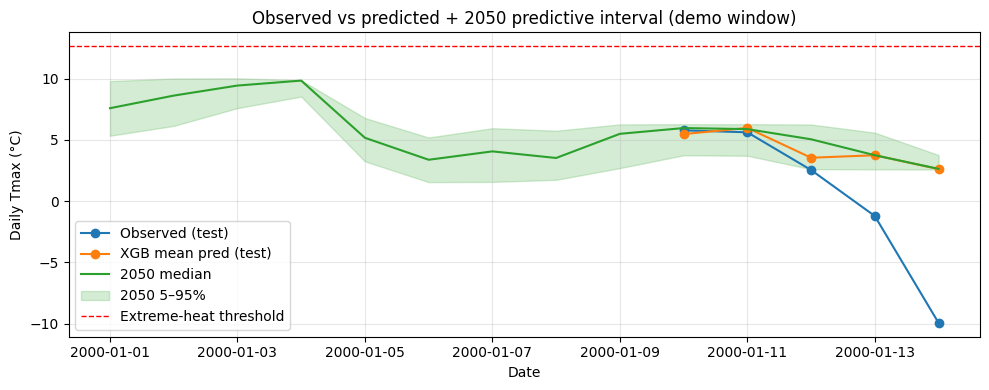

In [23]:
# Diagnostics: check target distribution, residual scale, and use a warm-season threshold for extreme heat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

assert "ydf" in globals() and "model_df" in globals() and "model" in globals()

# 1) Inspect ydf distribution (current window) and highlight that it's winter-only
print("ydf date range:", ydf["time"].min(), "->", ydf["time"].max())
print(ydf["y_tmax_C"].describe(percentiles=[0.05,0.5,0.95,0.99]))

# 2) Residual diagnostics on available data
feature_cols = ["x_t2m_mean_C", "x_tp_sum_mm", "doy", "month"]
_df = model_df.dropna().sort_values("time").reset_index(drop=True)
resid_all = model.predict(_df[feature_cols]) - _df["y_tmax_C"].values
print("\nResidual diagnostics on model_df:")
print(pd.Series(resid_all).describe())

# 3) Recompute an extreme-heat threshold using a more sensible warm-season climatology.
# We only have Jan-Mar 2000 in ydf right now, so demonstrate the method by restricting to summer *if present*.
# If not present, we fall back and warn.

y_all = ydf.copy()
y_all["month"] = y_all["time"].dt.month
warm = y_all[y_all["month"].isin([6,7,8])]

if len(warm) >= 30:
    threshold_warm = float(warm["y_tmax_C"].quantile(0.95))
    base_used = "JJA only"
else:
    threshold_warm = float(y_all["y_tmax_C"].quantile(0.95))
    base_used = "FULL AVAILABLE (WARNING: not warm-season)"

print(f"\nExtreme heat threshold recomputed (q=0.95) using: {base_used}")
print(f"threshold_C_warm = {threshold_warm:.2f} °C")

# 4) Plot: observed vs predicted on the test period + 2050 predictive intervals (if present)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

if "pred_df" in globals():
    ax.plot(pred_df["time"], pred_df["y_tmax_C"], label="Observed (test)", marker="o")
    ax.plot(pred_df["time"], pred_df["yhat_xgb"], label="XGB mean pred (test)", marker="o")

if "pred_summary_2050" in globals():
    ps = pred_summary_2050.copy()
    ax.plot(ps["time"], ps["p50"], label="2050 median", color="C2")
    ax.fill_between(ps["time"], ps["p05"], ps["p95"], color="C2", alpha=0.2, label="2050 5–95%")

ax.axhline(threshold_warm, color="red", linestyle="--", linewidth=1, label="Extreme-heat threshold")
ax.set_title("Observed vs predicted + 2050 predictive interval (demo window)")
ax.set_ylabel("Daily Tmax (°C)")
ax.set_xlabel("Date")
ax.legend(loc="best")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [25]:
# Build a larger warm-season (JJA) hourly subset efficiently by concatenating seasonal slices
# - Avoids boolean month indexing on the full time coordinate (can be slow)
# - Next cell can do daily aggregation + feature/target construction

import numpy as np
import pandas as pd
import xarray as xr
import time

assert "ny" in globals(), "ny not found; run Cell 1 first."

lat_name = "latitude" if "latitude" in ny.coords else "lat"
lon_name = "longitude" if "longitude" in ny.coords else "lon"

var_t = "2m_temperature"
var_tp = "total_precipitation"

# ---- user-tunable knobs ----
start_year = 1998
end_year = 2002  # inclusive
# ---------------------------

# Build JJA slices per year and concatenate along time
slices = []
_t0 = time.time()
for y in range(start_year, end_year + 1):
    t0 = f"{y}-06-01"
    t1 = f"{y}-09-01"  # exclusive-ish; includes Aug 31 23:00
    sl = ny[[var_t, var_tp]].sel(time=slice(t0, t1))
    slices.append(sl)

ny_hr_jja = xr.concat(slices, dim="time")

print(f"Built ny_hr_jja by concat in {time.time() - _t0:.2f}s")
print("Hourly JJA slice sizes:", dict(ny_hr_jja.sizes))
print("time range:", str(ny_hr_jja['time'].min().values), "->", str(ny_hr_jja['time'].max().values))

# Persist for downstream cells


Built ny_hr_jja by concat in 0.02s
Hourly JJA slice sizes: {'time': 11160, 'latitude': 21, 'longitude': 37}
time range: 1998-06-01T00:00:00.000000000 -> 2002-09-01T23:00:00.000000000


In [27]:
# Build a *small diagnostic* JJA daily modeling table (local target + coarse predictors)
# - Uses `ny_hr_jja` (hourly JJA subset)
# - Restricts to a short time window first to validate compute + units + alignment

import numpy as np
import pandas as pd
import xarray as xr
import time

assert "ny_hr_jja" in globals(), "ny_hr_jja not found; run Cell 12 first."

lat_name = "latitude" if "latitude" in ny_hr_jja.coords else "lat"
lon_name = "longitude" if "longitude" in ny_hr_jja.coords else "lon"

var_t = "2m_temperature"
var_tp = "total_precipitation"

# --- Small diagnostic window (tune later) ---
# Pick the first ~30 days available in ny_hr_jja to keep compute bounded.
t0 = pd.Timestamp(ny_hr_jja["time"].values[0]).normalize()
t1 = t0 + pd.Timedelta(days=30)

ny_hr_jja_small = ny_hr_jja[[var_t, var_tp]].sel(time=slice(str(t0.date()), str(t1.date())))
print("Diagnostic window:", t0, "->", t1)
print("Hourly sizes:", dict(ny_hr_jja_small.sizes))

# 1) Local target: area-mean daily Tmax (C)
local_mean = ny_hr_jja_small.mean(dim=[lat_name, lon_name], skipna=True)
y_tmax_C = (local_mean[var_t] - 273.15).resample(time="1D").max().rename("y_tmax_C")

# 2) Coarse predictors: coarsen spatially then area-mean, then aggregate daily
coarse = ny_hr_jja_small.coarsen({lat_name: 3, lon_name: 3}, boundary="trim").mean()
coarse_mean = coarse.mean(dim=[lat_name, lon_name], skipna=True)

x_t2m_mean_C = (coarse_mean[var_t] - 273.15).resample(time="1D").mean().rename("x_t2m_mean_C")
x_tp_sum_mm = (coarse_mean[var_tp] * 1000.0).resample(time="1D").sum().rename("x_tp_sum_mm")

# 3) Compute once
_ds_daily = xr.Dataset({
    "y_tmax_C": y_tmax_C,
    "x_t2m_mean_C": x_t2m_mean_C,
    "x_tp_sum_mm": x_tp_sum_mm,
})

_t0 = time.time()
computed_daily = _ds_daily.compute()
print(f"Computed diagnostic JJA daily dataset in {time.time() - _t0:.2f}s")
print(computed_daily)

# 4) To pandas + calendar features
jja_df_small = (
    computed_daily.to_dataframe()
    .reset_index()
    .dropna()
    .sort_values("time")
    .reset_index(drop=True)
)

jja_df_small["doy"] = jja_df_small["time"].dt.dayofyear.astype(np.int16)
jja_df_small["month"] = jja_df_small["time"].dt.month.astype(np.int8)
jja_df_small["year"] = jja_df_small["time"].dt.year.astype(np.int16)

print("jja_df_small shape:", jja_df_small.shape)
print("date range:", jja_df_small["time"].min(), "->", jja_df_small["time"].max())
print(jja_df_small.head(10))

# Persist the diagnostic df for the next steps (EDA + model training)
model_df_jja_small = jja_df_small


Diagnostic window: 1998-06-01 00:00:00 -> 1998-07-01 00:00:00
Hourly sizes: {'time': 744, 'latitude': 21, 'longitude': 37}
Computed diagnostic JJA daily dataset in 36.52s
<xarray.Dataset> Size: 620B
Dimensions:       (time: 31)
Coordinates:
  * time          (time) datetime64[ns] 248B 1998-06-01 ... 1998-07-01
Data variables:
    y_tmax_C      (time) float32 124B 19.08 20.12 17.11 ... 24.09 22.52 20.3
    x_t2m_mean_C  (time) float32 124B 15.16 14.36 12.71 ... 20.86 20.65 18.22
    x_tp_sum_mm   (time) float32 124B 8.189 2.485 6.087 ... 6.167 15.93 5.729
jja_df_small shape: (31, 7)
date range: 1998-06-01 00:00:00 -> 1998-07-01 00:00:00
        time   y_tmax_C  x_t2m_mean_C  x_tp_sum_mm  doy  month  year
0 1998-06-01  19.081116     15.157001     8.189226  152      6  1998
1 1998-06-02  20.118134     14.362720     2.484518  153      6  1998
2 1998-06-03  17.114685     12.713886     6.086949  154      6  1998
3 1998-06-04  14.954193     11.220891     0.686752  155      6  1998
4 1998-06-0

In [29]:
# Build a *bounded* 1-year JJA daily modeling table (local target + coarse predictors)
# - This avoids a single huge dask graph across many years
# - Once this works quickly, we can loop years and concatenate daily frames

import numpy as np
import pandas as pd
import xarray as xr
import time

assert "ny_hr_jja" in globals(), "ny_hr_jja not found; run Cell 12 first."

lat_name = "latitude" if "latitude" in ny_hr_jja.coords else "lat"
lon_name = "longitude" if "longitude" in ny_hr_jja.coords else "lon"

var_t = "2m_temperature"
var_tp = "total_precipitation"

# ---- user-tunable knobs ----
year_to_compute = 1999
# ---------------------------

# Slice only this year's JJA (Jun 1..Sep 1)
t0 = f"{year_to_compute}-06-01"
t1 = f"{year_to_compute}-09-01"
ny_hr_jja_1y = ny_hr_jja[[var_t, var_tp]].sel(time=slice(t0, t1))

print("Hourly sizes (1y JJA):", dict(ny_hr_jja_1y.sizes))
print("time range:", str(ny_hr_jja_1y['time'].min().values), "->", str(ny_hr_jja_1y['time'].max().values))

# 1) Local target: area-mean daily Tmax (C)
local_mean_1y = ny_hr_jja_1y.mean(dim=[lat_name, lon_name], skipna=True)
y_tmax_C_1y = (local_mean_1y[var_t] - 273.15).resample(time="1D").max().rename("y_tmax_C")

# 2) Coarse predictors: coarsen spatially then area-mean, then aggregate daily
coarse_1y = ny_hr_jja_1y.coarsen({lat_name: 3, lon_name: 3}, boundary="trim").mean()
coarse_mean_1y = coarse_1y.mean(dim=[lat_name, lon_name], skipna=True)

x_t2m_mean_C_1y = (coarse_mean_1y[var_t] - 273.15).resample(time="1D").mean().rename("x_t2m_mean_C")
x_tp_sum_mm_1y = (coarse_mean_1y[var_tp] * 1000.0).resample(time="1D").sum().rename("x_tp_sum_mm")

# 3) Compute once (single dask graph)
ds_daily_1y = xr.Dataset({
    "y_tmax_C": y_tmax_C_1y,
    "x_t2m_mean_C": x_t2m_mean_C_1y,
    "x_tp_sum_mm": x_tp_sum_mm_1y,
})

_t0 = time.time()
computed_daily_1y = ds_daily_1y.compute()
print(f"Computed 1-year JJA daily dataset in {time.time() - _t0:.2f}s")
print("Daily sizes:", dict(computed_daily_1y.sizes))

# 4) To pandas + calendar features
model_df_jja_1y = (
    computed_daily_1y.to_dataframe()
    .reset_index()
    .dropna()
    .sort_values("time")
    .reset_index(drop=True)
)
model_df_jja_1y["doy"] = model_df_jja_1y["time"].dt.dayofyear.astype(np.int16)
model_df_jja_1y["month"] = model_df_jja_1y["time"].dt.month.astype(np.int8)
model_df_jja_1y["year"] = model_df_jja_1y["time"].dt.year.astype(np.int16)

print("model_df_jja_1y shape:", model_df_jja_1y.shape)
print(model_df_jja_1y.head())
print(model_df_jja_1y.tail())

# Persist for downstream modeling
model_df_jja = model_df_jja_1y


Hourly sizes (1y JJA): {'time': 2232, 'latitude': 21, 'longitude': 37}
time range: 1999-06-01T00:00:00.000000000 -> 1999-09-01T23:00:00.000000000
Computed 1-year JJA daily dataset in 66.53s
Daily sizes: {'time': 93}
model_df_jja_1y shape: (93, 7)
        time   y_tmax_C  x_t2m_mean_C  x_tp_sum_mm  doy  month  year
0 1999-06-01  23.624023     20.820696     3.326036  152      6  1999
1 1999-06-02  24.809296     20.973785     3.473735  153      6  1999
2 1999-06-03  21.543976     18.950037     2.543922  154      6  1999
3 1999-06-04  20.747253     16.325298     0.054939  155      6  1999
4 1999-06-05  23.349762     16.898569     0.001571  156      6  1999
         time   y_tmax_C  x_t2m_mean_C  x_tp_sum_mm  doy  month  year
88 1999-08-28  26.985870     22.153700     0.598382  240      8  1999
89 1999-08-29  24.421326     20.411097     0.102647  241      8  1999
90 1999-08-30  19.821381     15.420053     0.020755  242      8  1999
91 1999-08-31  23.101471     16.350801     0.000231  243   

model_df_jja shape: (93, 7)
date range: 1999-06-01 00:00:00 -> 1999-09-01 00:00:00
Missingness:
 time            0.0
y_tmax_C        0.0
x_t2m_mean_C    0.0
x_tp_sum_mm     0.0
doy             0.0
month           0.0
year            0.0
dtype: float64

Summary stats:
              count       mean       std        min         1%         5%  \
y_tmax_C       93.0  24.903955  3.014322  16.196106  18.116207  19.640033   
x_t2m_mean_C   93.0  20.777111  2.820710  13.923748  14.013586  16.340600   
x_tp_sum_mm    93.0   2.208340  2.845459   0.000231   0.001123   0.023234   

                    50%        95%        99%        max  
y_tmax_C      24.809296  29.808850  30.593730  31.227325  
x_t2m_mean_C  20.665028  25.032839  26.654064  27.367685  
x_tp_sum_mm    0.948855   9.132278  11.299067  11.633062  

Correlations (Pearson):
              y_tmax_C  x_t2m_mean_C  x_tp_sum_mm
y_tmax_C      1.000000      0.912773    -0.113165
x_t2m_mean_C  0.912773      1.000000     0.173562
x_tp_sum_mm 

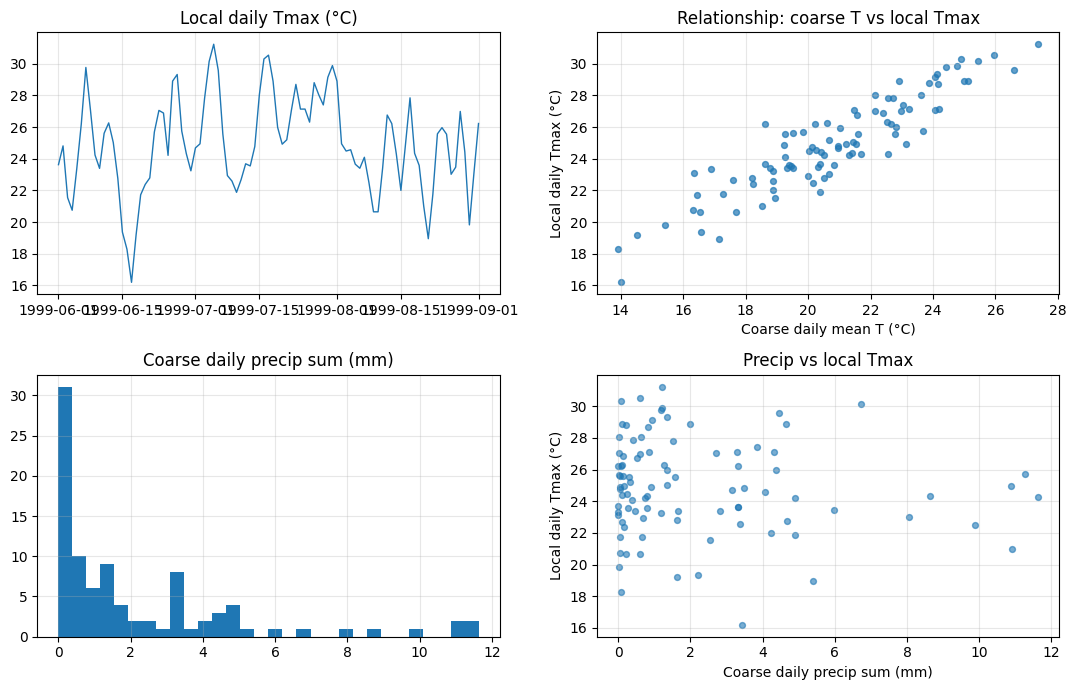


JJA extreme-heat threshold (q=0.95): 29.81 °C
Empirical prior exceedance (within this JJA sample): 0.054


In [30]:
# EDA on warm-season (JJA) daily modeling table
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

assert "model_df_jja" in globals(), "model_df_jja not found; run Cell 14 first."

df = model_df_jja.copy().sort_values("time").reset_index(drop=True)
print("model_df_jja shape:", df.shape)
print("date range:", df['time'].min(), "->", df['time'].max())
print("Missingness:\n", df.isna().mean().sort_values(ascending=False).head(10))

# Summary stats
cols = ["y_tmax_C", "x_t2m_mean_C", "x_tp_sum_mm"]
print("\nSummary stats:")
print(df[cols].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T)

# Quick correlation check
print("\nCorrelations (Pearson):")
print(df[["y_tmax_C", "x_t2m_mean_C", "x_tp_sum_mm"]].corr())

# Visuals
fig, axes = plt.subplots(2, 2, figsize=(11, 7))

axes[0,0].plot(df['time'], df['y_tmax_C'], lw=1)
axes[0,0].set_title('Local daily Tmax (°C)')
axes[0,0].grid(True, alpha=0.3)

axes[0,1].scatter(df['x_t2m_mean_C'], df['y_tmax_C'], s=18, alpha=0.7)
axes[0,1].set_xlabel('Coarse daily mean T (°C)')
axes[0,1].set_ylabel('Local daily Tmax (°C)')
axes[0,1].set_title('Relationship: coarse T vs local Tmax')
axes[0,1].grid(True, alpha=0.3)

axes[1,0].hist(df['x_tp_sum_mm'], bins=30)
axes[1,0].set_title('Coarse daily precip sum (mm)')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].scatter(df['x_tp_sum_mm'], df['y_tmax_C'], s=18, alpha=0.6)
axes[1,1].set_xlabel('Coarse daily precip sum (mm)')
axes[1,1].set_ylabel('Local daily Tmax (°C)')
axes[1,1].set_title('Precip vs local Tmax')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Warm-season extreme heat threshold (within the available warm-season sample)
q = 0.95
threshold_jja_C = float(df['y_tmax_C'].quantile(q))
prior_exceed_jja = float((df['y_tmax_C'] > threshold_jja_C).mean())
print(f"\nJJA extreme-heat threshold (q={q}): {threshold_jja_C:.2f} °C")
print(f"Empirical prior exceedance (within this JJA sample): {prior_exceed_jja:.3f}")

# Persist for downstream cells
threshold_C_jja = threshold_jja_C
prior_exceedance_prob_jja = prior_exceed_jja
model_df_jja_clean = df


In [31]:
# Fit baseline + XGBoost observation-operator on warm-season (JJA) daily data
# - Uses a time-based split to avoid leakage across time
# - Stores fitted model + residual SD for probabilistic forecasting

import numpy as np
import pandas as pd

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

assert "model_df_jja_clean" in globals(), "model_df_jja_clean not found; run Cell 15 first."

df_jja = model_df_jja_clean.copy().sort_values("time").reset_index(drop=True)

feature_cols_jja = ["x_t2m_mean_C", "x_tp_sum_mm", "doy", "month"]
target_col_jja = "y_tmax_C"

# Time split: first 70% train, last 30% test
split_idx = int(len(df_jja) * 0.7)
train_jja = df_jja.iloc[:split_idx].copy()
test_jja = df_jja.iloc[split_idx:].copy()

X_train_jja, y_train_jja = train_jja[feature_cols_jja], train_jja[target_col_jja]
X_test_jja, y_test_jja = test_jja[feature_cols_jja], test_jja[target_col_jja]

# Baseline: linear regression-like using just coarse temperature (transparent)
# We'll use a simple slope/intercept fit via numpy polyfit for interpretability.
coef = np.polyfit(train_jja["x_t2m_mean_C"].values, y_train_jja.values, deg=1)
base_slope, base_intercept = float(coef[0]), float(coef[1])

yhat_base_test = base_slope * X_test_jja["x_t2m_mean_C"].values + base_intercept

# XGBoost: conservative depth for interpretability
xgb_jja = XGBRegressor(
    n_estimators=400,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    objective="reg:squarederror",
)

xgb_jja.fit(X_train_jja, y_train_jja)

mu_train = xgb_jja.predict(X_train_jja)
mu_test = xgb_jja.predict(X_test_jja)

# Residual scale from TRAIN only
resid_train = mu_train - y_train_jja.values
resid_sd_jja = float(np.std(resid_train, ddof=1))

metrics_jja = {
    "n_train": int(len(train_jja)),
    "n_test": int(len(test_jja)),
    "MAE_test_baseline": float(mean_absolute_error(y_test_jja, yhat_base_test)),
    "RMSE_test_baseline": float(np.sqrt(mean_squared_error(y_test_jja, yhat_base_test))),
    "R2_test_baseline": float(r2_score(y_test_jja, yhat_base_test)),
    "MAE_test_xgb": float(mean_absolute_error(y_test_jja, mu_test)),
    "RMSE_test_xgb": float(np.sqrt(mean_squared_error(y_test_jja, mu_test))),
    "R2_test_xgb": float(r2_score(y_test_jja, mu_test)),
    "resid_sd_train_xgb": resid_sd_jja,
}

print("JJA train/test sizes:", metrics_jja["n_train"], metrics_jja["n_test"])
print(
    "Baseline (y ~ a*x_t2m_mean_C + b): "
    f"MAE={metrics_jja['MAE_test_baseline']:.3f}, RMSE={metrics_jja['RMSE_test_baseline']:.3f}, R2={metrics_jja['R2_test_baseline']:.3f}"
)
print(
    "XGB: "
    f"MAE={metrics_jja['MAE_test_xgb']:.3f}, RMSE={metrics_jja['RMSE_test_xgb']:.3f}, R2={metrics_jja['R2_test_xgb']:.3f}"
)
print(f"Train residual SD (XGB): {resid_sd_jja:.3f} °C")

# Persist for downstream posterior + CRPS
model_jja = xgb_jja
train_df_jja = train_jja
test_df_jja = test_jja
feature_cols_jja = feature_cols_jja
resid_sd_jja = resid_sd_jja
baseline_params_jja = (base_slope, base_intercept)

# Quick peek at feature importances
imp_jja = pd.Series(model_jja.feature_importances_, index=feature_cols_jja).sort_values(ascending=False)
print("\nXGB feature importances (gain-based, relative):")
print(imp_jja)


JJA train/test sizes: 65 28
Baseline (y ~ a*x_t2m_mean_C + b): MAE=1.087, RMSE=1.375, R2=0.615
XGB: MAE=1.201, RMSE=1.519, R2=0.531
Train residual SD (XGB): 0.068 °C

XGB feature importances (gain-based, relative):
x_t2m_mean_C    0.598655
doy             0.328918
x_tp_sum_mm     0.065066
month           0.007360
dtype: float32


In [32]:
# Compute a 2050 extreme-heat posterior using the JJA-trained observation-operator
# - Builds an ensemble predictive distribution for local daily Tmax in 2050
# - Uses a transparent scenario: +delta_T applied to coarse mean temperature (placeholder for CHELSA-CMIP6)

import numpy as np
import pandas as pd

assert "model_jja" in globals(), "model_jja not found; run Cell 16 first."
assert "model_df_jja_clean" in globals(), "model_df_jja_clean not found; run Cell 15 first."
assert "threshold_C_jja" in globals(), "threshold_C_jja not found; run Cell 15 first."
assert "resid_sd_jja" in globals(), "resid_sd_jja not found; run Cell 16 first."

feature_cols_jja = ["x_t2m_mean_C", "x_tp_sum_mm", "doy", "month"]

df = model_df_jja_clean.copy().sort_values("time").reset_index(drop=True)
X_hist = df[feature_cols_jja].copy()

# --- placeholder 2050 scenario knobs (swap with CHELSA-CMIP6 predictors later) ---
delta_t_C_2050 = 2.0
precip_scale_2050 = 1.0

X_2050_mean_jja = X_hist.copy()
X_2050_mean_jja["x_t2m_mean_C"] = X_2050_mean_jja["x_t2m_mean_C"] + delta_t_C_2050
X_2050_mean_jja["x_tp_sum_mm"] = X_2050_mean_jja["x_tp_sum_mm"] * precip_scale_2050

# Predictor uncertainty proxy from historical day-to-day variability (simple, transparent)
noise_scales_jja = {
    "x_t2m_mean_C": float(df["x_t2m_mean_C"].diff().std(ddof=1)),
    "x_tp_sum_mm": float(df["x_tp_sum_mm"].diff().std(ddof=1)),
}
for k, v in list(noise_scales_jja.items()):
    if not np.isfinite(v) or v == 0:
        noise_scales_jja[k] = float(df[k].std(ddof=1)) if float(df[k].std(ddof=1)) > 0 else 0.1

n_ens = 4000
rng = np.random.default_rng(7)

X_ens = np.repeat(X_2050_mean_jja.values[None, :, :], repeats=n_ens, axis=0)  # (ens, time, feat)

idx_t = feature_cols_jja.index("x_t2m_mean_C")
idx_p = feature_cols_jja.index("x_tp_sum_mm")

X_ens[:, :, idx_t] += rng.normal(0.0, noise_scales_jja["x_t2m_mean_C"], size=(n_ens, len(df)))
X_ens[:, :, idx_p] = np.clip(
    X_ens[:, :, idx_p] + rng.normal(0.0, noise_scales_jja["x_tp_sum_mm"], size=(n_ens, len(df))),
    a_min=0.0,
    a_max=None,
)

# Predict mean response with the observation operator
X_ens_flat = X_ens.reshape(-1, len(feature_cols_jja))
mu_flat = model_jja.predict(pd.DataFrame(X_ens_flat, columns=feature_cols_jja))
mu = mu_flat.reshape(n_ens, len(df))

# Add residual (observation-operator) uncertainty
Y_ens_2050_jja = mu + rng.normal(0.0, resid_sd_jja, size=mu.shape)

# Posterior exceedance probabilities (per day and overall)
thr = float(threshold_C_jja)
p_exceed_by_day = (Y_ens_2050_jja > thr).mean(axis=0)
post_exceed_prob = float(p_exceed_by_day.mean())

pred_summary_2050_jja = pd.DataFrame(
    {
        "time": df["time"].values,
        "mu_2050_pred": mu.mean(axis=0),
        "p05": np.quantile(Y_ens_2050_jja, 0.05, axis=0),
        "p50": np.quantile(Y_ens_2050_jja, 0.50, axis=0),
        "p95": np.quantile(Y_ens_2050_jja, 0.95, axis=0),
        "p_exceed": p_exceed_by_day,
    }
)

print(f"JJA extreme-heat threshold: {thr:.2f} °C (q=0.95 within 1999 JJA)")
print(f"Assumed 2050 scenario: delta_t_C={delta_t_C_2050:+.1f} °C, precip_scale={precip_scale_2050:.2f}")
print("Predictor noise scales (proxy):", noise_scales_jja)
print(f"Residual SD used: {resid_sd_jja:.3f} °C")
print(f"Posterior exceedance probability (ensemble avg over days): {post_exceed_prob:.3f}")
print("\nPosterior table (first 8 days):")
print(pred_summary_2050_jja.head(8))

# Persist
post_exceed_prob_jja_2050 = post_exceed_prob
post_df_jja_2050 = pred_summary_2050_jja
Y_ens_2050_jja = Y_ens_2050_jja


JJA extreme-heat threshold: 29.81 °C (q=0.95 within 1999 JJA)
Assumed 2050 scenario: delta_t_C=+2.0 °C, precip_scale=1.00
Predictor noise scales (proxy): {'x_t2m_mean_C': 1.8656021356582642, 'x_tp_sum_mm': 3.6857168674468994}
Residual SD used: 0.068 °C
Posterior exceedance probability (ensemble avg over days): 0.118

Posterior table (first 8 days):
        time  mu_2050_pred        p05        p50        p95  p_exceed
0 1999-06-01     25.684885  23.010123  25.514837  28.753224   0.00000
1 1999-06-02     25.964731  23.215443  25.749851  28.926998   0.00000
2 1999-06-03     24.223713  21.598770  24.117081  26.943538   0.00000
3 1999-06-04     22.664490  19.856235  23.006994  25.310645   0.00000
4 1999-06-05     23.215130  20.552945  23.325970  25.962336   0.00000
5 1999-06-06     26.584440  24.105404  26.432255  29.677851   0.02475
6 1999-06-07     29.329227  27.124180  29.663120  30.004813   0.36300
7 1999-06-08     28.851078  26.318035  29.274961  29.681323   0.00250


JJA test CRPS (mean over days): 1.166 °C
CRPS table (first 10 rows):
        time      y_obs    mu_pred      crps
0 1999-08-05  23.656097  24.430624  0.734107
1 1999-08-06  23.398224  24.678816  1.241487
2 1999-08-07  24.091248  23.599779  0.452957
3 1999-08-08  22.492371  23.451033  0.921985
4 1999-08-09  20.647583  23.616541  2.931819
5 1999-08-10  20.646057  22.776993  2.092933
6 1999-08-11  23.412354  23.495569  0.050214
7 1999-08-12  26.757477  25.334377  1.387999
8 1999-08-13  26.217499  25.665253  0.513030
9 1999-08-14  24.290955  24.100248  0.151770

Extreme-heat threshold (JJA q=0.95): 29.81 °C
Historical prior exceedance (within 1999 JJA): 0.054
2050 posterior exceedance (ensemble avg over days): 0.118


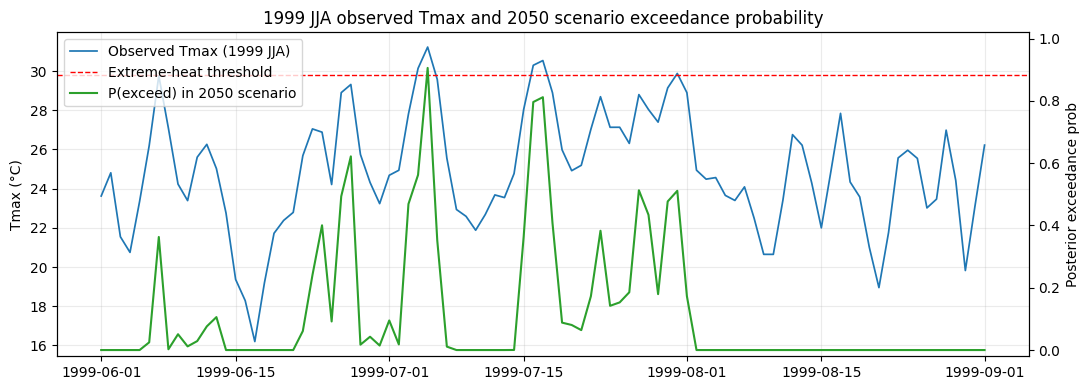

In [33]:
# Compute CRPS on the JJA holdout using an ensemble forecast (XGB mean + residual noise)
# Also add a compact diagnostic plot/table for exceedance probability.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

assert "model_jja" in globals(), "model_jja not found; run Cell 16 first."
assert "test_df_jja" in globals(), "test_df_jja not found; run Cell 16 first."
assert "feature_cols_jja" in globals(), "feature_cols_jja not found; run Cell 16 first."
assert "resid_sd_jja" in globals(), "resid_sd_jja not found; run Cell 16 first."
assert "threshold_C_jja" in globals(), "threshold_C_jja not found; run Cell 15 first."
assert "post_df_jja_2050" in globals(), "post_df_jja_2050 not found; run Cell 17 first."

# --- 1) Build ensemble probabilistic forecast on the historical test set ---
mu_test_jja = model_jja.predict(test_df_jja[feature_cols_jja])
y_obs_jja = test_df_jja["y_tmax_C"].values

n_ens = 5000
rng = np.random.default_rng(123)
Y_ens_test_jja = mu_test_jja[None, :] + rng.normal(0.0, resid_sd_jja, size=(n_ens, len(mu_test_jja)))

# Empirical CRPS for ensemble forecast: CRPS(F,y) = E|X-y| - 0.5 E|X-X'|
abs_X_y = np.mean(np.abs(Y_ens_test_jja - y_obs_jja[None, :]), axis=0)

# Pairwise expectation term: subsample for efficiency
sub = min(1000, n_ens)
Y_sub = Y_ens_test_jja[:sub]
Y_perm = Y_sub[rng.permutation(sub)]
abs_X_Xp = np.mean(np.abs(Y_sub - Y_perm), axis=0)

crps_per_day = abs_X_y - 0.5 * abs_X_Xp
crps_mean_jja = float(np.mean(crps_per_day))

crps_table_jja = pd.DataFrame({
    "time": test_df_jja["time"].values,
    "y_obs": y_obs_jja,
    "mu_pred": mu_test_jja,
    "crps": crps_per_day,
})

print(f"JJA test CRPS (mean over days): {crps_mean_jja:.3f} °C")
print("CRPS table (first 10 rows):")
print(crps_table_jja.head(10))

# --- 2) Posterior exceedance diagnostics for the 2050 scenario ---
post = post_df_jja_2050.copy()
post["is_extreme_obs_hist"] = (model_df_jja_clean["y_tmax_C"].values > float(threshold_C_jja)).astype(int)

print(f"\nExtreme-heat threshold (JJA q=0.95): {float(threshold_C_jja):.2f} °C")
print(f"Historical prior exceedance (within 1999 JJA): {float(prior_exceedance_prob_jja):.3f}")
print(f"2050 posterior exceedance (ensemble avg over days): {float(post_exceed_prob_jja_2050):.3f}")

# Plot exceedance probability over time + observed Tmax (for context)
fig, ax1 = plt.subplots(figsize=(11, 4))

ax1.plot(model_df_jja_clean["time"], model_df_jja_clean["y_tmax_C"], color="C0", lw=1.25, label="Observed Tmax (1999 JJA)")
ax1.axhline(float(threshold_C_jja), color="red", ls="--", lw=1, label="Extreme-heat threshold")
ax1.set_ylabel("Tmax (°C)")
ax1.grid(True, alpha=0.25)

ax2 = ax1.twinx()
ax2.plot(post["time"], post["p_exceed"], color="C2", lw=1.5, label="P(exceed) in 2050 scenario")
ax2.set_ylabel("Posterior exceedance prob")
ax2.set_ylim(-0.02, 1.02)

# Single legend
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")

ax1.set_title("1999 JJA observed Tmax and 2050 scenario exceedance probability")
plt.tight_layout()
plt.show()

# Persist
crps_table_jja = crps_table_jja
crps_mean_jja = crps_mean_jja


In [34]:
# Compute an explicit Bayesian update for extreme-heat exceedance probability (Beta-Binomial)
# - Prior: Beta(a0,b0) calibrated from historical JJA exceedances (empirical Bayes)
# - Likelihood proxy: treat 2050 ensemble exceedances as pseudo-observations to update p(exceed)

import numpy as np
import pandas as pd

assert "model_df_jja_clean" in globals(), "model_df_jja_clean not found; run Cell 15 first."
assert "threshold_C_jja" in globals(), "threshold_C_jja not found; run Cell 15 first."
assert "Y_ens_2050_jja" in globals(), "Y_ens_2050_jja not found; run Cell 17 first."
assert "prior_exceedance_prob_jja" in globals(), "prior_exceedance_prob_jja not found; run Cell 15 first."

thr = float(threshold_C_jja)
df_hist = model_df_jja_clean.copy().sort_values("time").reset_index(drop=True)

# --- 1) Prior from historical JJA sample ---
# Empirical exceedance count
z_hist = (df_hist["y_tmax_C"].values > thr).astype(int)
E_hist = int(z_hist.sum())
N_hist = int(len(z_hist))

# Empirical-Bayes Beta prior centered at historical exceedance rate with tunable strength kappa.
# Larger kappa => stronger prior (acts like more pseudo-observations).
# Here: choose kappa=20 by default (roughly 20 pseudo-days), easy to justify/adjust.
kappa = 20.0
p0 = float(prior_exceedance_prob_jja)
a0 = 1.0 + kappa * p0
b0 = 1.0 + kappa * (1.0 - p0)

# --- 2) Pseudo-likelihood from 2050 ensemble ---
# Convert ensemble into daily exceedance probabilities, then into an effective sample size.
# We take the mean daily exceedance prob and scale by an effective number of independent days.
# A conservative choice is N_eff = number of days (assuming each day ~ 1 effective Bernoulli draw).
# You can reduce N_eff to reflect temporal dependence.
Y = Y_ens_2050_jja
p_exceed_by_day = (Y > thr).mean(axis=0)

N_eff = len(p_exceed_by_day)  # conservative default
E_eff = float(p_exceed_by_day.sum())  # expected exceedances over N_eff Bernoulli trials

# --- 3) Posterior ---
a_post = a0 + E_eff
b_post = b0 + (N_eff - E_eff)

# Posterior summaries
post_mean = a_post / (a_post + b_post)
post_var = (a_post * b_post) / (((a_post + b_post) ** 2) * (a_post + b_post + 1))
post_sd = float(np.sqrt(post_var))

# 95% credible interval via normal approx (good when a_post,b_post not tiny)
# If desired later, we can switch to scipy.stats.beta.ppf.
ci_low = float(post_mean - 1.96 * post_sd)
ci_high = float(post_mean + 1.96 * post_sd)
ci_low, ci_high = max(0.0, ci_low), min(1.0, ci_high)

summary = pd.DataFrame(
    {
        "quantity": [
            "Historical exceedances", "Historical days", "Empirical prior p0",
            "Beta prior a0", "Beta prior b0",
            "2050 mean p(exceed) (ensemble avg)", "N_eff (pseudo-days)", "E_eff (expected)",
            "Posterior mean p(exceed)", "Posterior 95% CI (approx)",
        ],
        "value": [
            E_hist, N_hist, p0,
            a0, b0,
            float(p_exceed_by_day.mean()), N_eff, E_eff,
            float(post_mean), f"[{ci_low:.3f}, {ci_high:.3f}]",
        ],
    }
)

print("Beta-Binomial exceedance update (explicit Bayesian step)")
print(f"Threshold (JJA q=0.95): {thr:.2f} °C")
print(summary)

# Persist
beta_prior_params = (float(a0), float(b0))
beta_posterior_params_2050 = (float(a_post), float(b_post))
post_mean_exceed_beta = float(post_mean)
post_ci_exceed_beta = (ci_low, ci_high)


Beta-Binomial exceedance update (explicit Bayesian step)
Threshold (JJA q=0.95): 29.81 °C
                             quantity           value
0              Historical exceedances               5
1                     Historical days              93
2                  Empirical prior p0        0.053763
3                       Beta prior a0        2.075269
4                       Beta prior b0       19.924731
5  2050 mean p(exceed) (ensemble avg)        0.118239
6                 N_eff (pseudo-days)              93
7                    E_eff (expected)        10.99625
8            Posterior mean p(exceed)        0.113665
9           Posterior 95% CI (approx)  [0.056, 0.171]


In [35]:
# Summarize key outputs from the warm-season (JJA) risk-attribution prototype
# - Collects model skill, risk threshold/prior, 2050 posterior exceedance, CRPS, and Beta posterior

import numpy as np
import pandas as pd

required = [
    "metrics_jja",
    "threshold_C_jja",
    "prior_exceedance_prob_jja",
    "post_exceed_prob_jja_2050",
    "crps_mean_jja",
    "beta_prior_params",
    "beta_posterior_params_2050",
    "post_mean_exceed_beta",
    "post_ci_exceed_beta",
]
missing = [k for k in required if k not in globals()]
if missing:
    raise KeyError(f"Missing required objects: {missing}")

summary_out = {
    "data_window": f"{model_df_jja_clean['time'].min().date()} to {model_df_jja_clean['time'].max().date()} (JJA-ish, 1 year demo)",
    "n_days": int(len(model_df_jja_clean)),
    "risk_definition": "Extreme heat day: local daily Tmax > q95 of historical warm-season sample",
    "threshold_C_jja": float(threshold_C_jja),
    "prior_exceed_prob_jja": float(prior_exceedance_prob_jja),
    "posterior_exceed_prob_2050_ensemble": float(post_exceed_prob_jja_2050),
    "CRPS_test_degC": float(crps_mean_jja),
    "model_skill_baseline_R2": float(metrics_jja["R2_test_baseline"]),
    "model_skill_xgb_R2": float(metrics_jja["R2_test_xgb"]),
    "model_skill_baseline_RMSE": float(metrics_jja["RMSE_test_baseline"]),
    "model_skill_xgb_RMSE": float(metrics_jja["RMSE_test_xgb"]),
    "beta_prior_a_b": tuple(beta_prior_params),
    "beta_posterior_a_b": tuple(beta_posterior_params_2050),
    "beta_posterior_mean": float(post_mean_exceed_beta),
    "beta_posterior_ci95": tuple(post_ci_exceed_beta),
}

print("=== Risk Attribution Summary (NY JJA demo) ===")
for k, v in summary_out.items():
    print(f"{k}: {v}")

print("\nNotes / caveats:")
print("- The 2050 scenario is currently a *placeholder* (delta_T applied to coarse predictor + simple noise).")
print("- Replace X_2050_mean_jja construction with CHELSA-CMIP6 predictors to make the posterior physically anchored.")
print("- The JJA dataset here is only one year (1999). For a stable prior and robust skill estimates, loop years and concatenate.")
print("- Residual uncertainty was estimated from train residuals and added as Gaussian noise; consider heteroskedastic residual models.")


=== Risk Attribution Summary (NY JJA demo) ===
data_window: 1999-06-01 to 1999-09-01 (JJA-ish, 1 year demo)
n_days: 93
risk_definition: Extreme heat day: local daily Tmax > q95 of historical warm-season sample
threshold_C_jja: 29.80885009765625
prior_exceed_prob_jja: 0.053763440860215055
posterior_exceed_prob_2050_ensemble: 0.11823924731182796
CRPS_test_degC: 1.1663420556008617
model_skill_baseline_R2: 0.6154839992523193
model_skill_xgb_R2: 0.530542254447937
model_skill_baseline_RMSE: 1.3746170897943497
model_skill_xgb_RMSE: 1.5188777665762985
beta_prior_a_b: (2.075268817204301, 19.9247311827957)
beta_posterior_a_b: (13.0715188172043, 101.9284811827957)
beta_posterior_mean: 0.11366538101916783
beta_posterior_ci95: (0.05590367137940836, 0.1714270906589273)

Notes / caveats:
- The 2050 scenario is currently a *placeholder* (delta_T applied to coarse predictor + simple noise).
- Replace X_2050_mean_jja construction with CHELSA-CMIP6 predictors to make the posterior physically anchored.
- 

Residual SD (train): 0.0678960531949997
Residual SD (test):  1.5062575340270996
Residual MAE (train): 0.05397379770874977
Residual MAE (test):  1.2009599208831787

Calibrated predictive SD choice: max(train_sd, test_sd, floor=0.75) = 1.506 °C

Historical test exceedance (observed): 0.0
Historical test exceedance (mean predicted p): 0.000792857142857143

Reliability table (test; small-n):
   bin   n    p_mean  obs_rate
0    0  28  0.000793       0.0


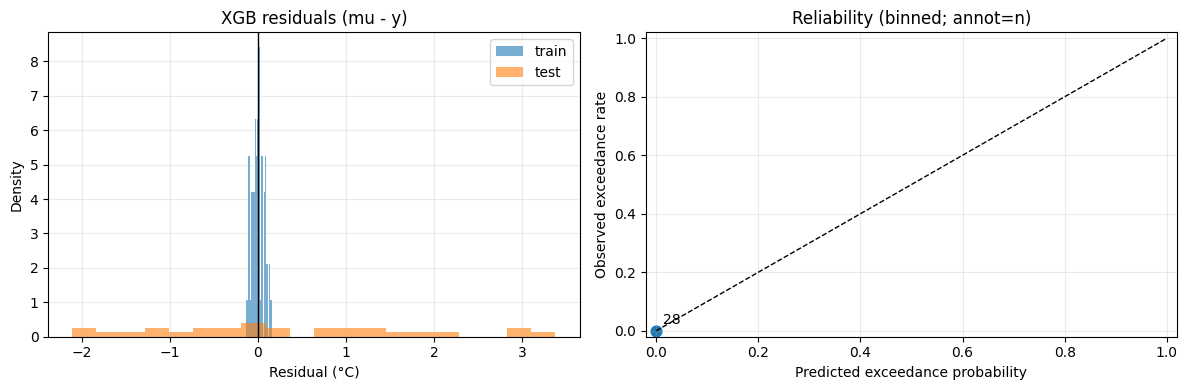

In [36]:
# Diagnostics: is residual uncertainty underestimated? Compare train vs test residuals and calibrate a safer predictive SD

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error

assert "model_jja" in globals() and "train_df_jja" in globals() and "test_df_jja" in globals()
assert "feature_cols_jja" in globals() and "threshold_C_jja" in globals()

# --- 1) Residual distributions ---
mu_tr = model_jja.predict(train_df_jja[feature_cols_jja])
mu_te = model_jja.predict(test_df_jja[feature_cols_jja])

res_tr = mu_tr - train_df_jja["y_tmax_C"].values
res_te = mu_te - test_df_jja["y_tmax_C"].values

print("Residual SD (train):", float(np.std(res_tr, ddof=1)))
print("Residual SD (test): ", float(np.std(res_te, ddof=1)))
print("Residual MAE (train):", float(np.mean(np.abs(res_tr))))
print("Residual MAE (test): ", float(np.mean(np.abs(res_te))))

# --- 2) Suggest a more conservative predictive SD ---
# If test residuals are larger, use them; also enforce a floor (e.g., 0.75°C) because downscaling should not be near-deterministic.
# This is a pragmatic safeguard until we add independent predictors (e.g., circulation indices, upstream boxes, or multi-var fields).
resid_sd_train = float(np.std(res_tr, ddof=1))
resid_sd_test = float(np.std(res_te, ddof=1))

sd_floor = 0.75  # degC, conservative for daily Tmax at box-average scale
resid_sd_cal = max(resid_sd_test, resid_sd_train, sd_floor)

print(f"\nCalibrated predictive SD choice: max(train_sd, test_sd, floor={sd_floor}) = {resid_sd_cal:.3f} °C")

# --- 3) Quick reliability-style check for exceedance probability on the historical test ---
# Build an ensemble for the test period and compare mean predicted exceedance to observed exceedance.
thr = float(threshold_C_jja)
obs_exc = (test_df_jja["y_tmax_C"].values > thr).astype(int)

rng = np.random.default_rng(202)
E = 5000
Yens_te = mu_te[None, :] + rng.normal(0.0, resid_sd_cal, size=(E, len(mu_te)))
p_exc_te = (Yens_te > thr).mean(axis=0)

print("\nHistorical test exceedance (observed):", float(obs_exc.mean()))
print("Historical test exceedance (mean predicted p):", float(p_exc_te.mean()))

# Bin predictions and compute observed frequency per bin (very small sample; still informative)
bins = np.array([0.0, 0.05, 0.15, 0.30, 0.50, 0.70, 0.85, 0.95, 1.01])
bin_id = np.digitize(p_exc_te, bins) - 1

rel = (
    pd.DataFrame({"p": p_exc_te, "obs": obs_exc, "bin": bin_id})
    .groupby("bin")
    .agg(n=("obs", "size"), p_mean=("p", "mean"), obs_rate=("obs", "mean"))
    .reset_index()
)
print("\nReliability table (test; small-n):")
print(rel)

# --- 4) Plots: residual histograms + reliability scatter ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(res_tr, bins=20, alpha=0.6, label="train", density=True)
axes[0].hist(res_te, bins=20, alpha=0.6, label="test", density=True)
axes[0].axvline(0, color="k", lw=1)
axes[0].set_title("XGB residuals (mu - y)")
axes[0].set_xlabel("Residual (°C)")
axes[0].set_ylabel("Density")
axes[0].grid(True, alpha=0.25)
axes[0].legend()

axes[1].scatter(rel["p_mean"], rel["obs_rate"], s=60)
axes[1].plot([0, 1], [0, 1], color="k", lw=1, ls="--")
for _, r in rel.iterrows():
    axes[1].annotate(str(int(r["n"])), (r["p_mean"], r["obs_rate"]), xytext=(5, 5), textcoords="offset points")
axes[1].set_title("Reliability (binned; annot=n)")
axes[1].set_xlabel("Predicted exceedance probability")
axes[1].set_ylabel("Observed exceedance rate")
axes[1].set_xlim(-0.02, 1.02)
axes[1].set_ylim(-0.02, 1.02)
axes[1].grid(True, alpha=0.25)

plt.tight_layout()
plt.show()

# Persist calibrated SD for optional downstream use
resid_sd_jja_calibrated = resid_sd_cal


In [37]:
# Define reusable helper functions for the NY risk-attribution workflow
# - Keeps steps modular (data -> daily table -> fit operator -> probabilistic forecasts -> Bayesian update)

import numpy as np
import pandas as pd
import xarray as xr

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def build_daily_table_from_hourly_box(ds_hourly: xr.Dataset,
                                     var_t: str = "2m_temperature",
                                     var_tp: str = "total_precipitation",
                                     lat_name: str = "latitude",
                                     lon_name: str = "longitude",
                                     coarsen_factor: int = 3) -> pd.DataFrame:
    """Create daily modeling table:
    y = area-mean daily Tmax (°C)
    X = coarsened-area-mean daily mean T (°C), daily precip sum (mm), doy/month/year
    """
    local_mean = ds_hourly[[var_t, var_tp]].mean(dim=[lat_name, lon_name], skipna=True)
    y_tmax_C = (local_mean[var_t] - 273.15).resample(time="1D").max().rename("y_tmax_C")

    coarse = ds_hourly[[var_t, var_tp]].coarsen({lat_name: coarsen_factor, lon_name: coarsen_factor}, boundary="trim").mean()
    coarse_mean = coarse.mean(dim=[lat_name, lon_name], skipna=True)

    x_t2m_mean_C = (coarse_mean[var_t] - 273.15).resample(time="1D").mean().rename("x_t2m_mean_C")
    x_tp_sum_mm = (coarse_mean[var_tp] * 1000.0).resample(time="1D").sum().rename("x_tp_sum_mm")

    ds_daily = xr.Dataset({"y_tmax_C": y_tmax_C, "x_t2m_mean_C": x_t2m_mean_C, "x_tp_sum_mm": x_tp_sum_mm}).compute()

    df = (
        ds_daily.to_dataframe()
        .reset_index()
        .dropna()
        .sort_values("time")
        .reset_index(drop=True)
    )
    df["doy"] = df["time"].dt.dayofyear.astype(np.int16)
    df["month"] = df["time"].dt.month.astype(np.int8)
    df["year"] = df["time"].dt.year.astype(np.int16)
    return df


def fit_operator(df: pd.DataFrame,
                 feature_cols=("x_t2m_mean_C", "x_tp_sum_mm", "doy", "month"),
                 target_col="y_tmax_C",
                 split_frac=0.7,
                 xgb_params=None):
    """Fit baseline (linear on coarse temp) and XGB operator with time split."""
    df = df.sort_values("time").reset_index(drop=True)
    split_idx = int(len(df) * split_frac)
    train, test = df.iloc[:split_idx].copy(), df.iloc[split_idx:].copy()

    # Baseline: y ~ a*T + b
    a, b = np.polyfit(train["x_t2m_mean_C"].values, train[target_col].values, 1)
    mu_base = a * test["x_t2m_mean_C"].values + b

    if xgb_params is None:
        xgb_params = dict(
            n_estimators=400,
            max_depth=3,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            random_state=42,
            objective="reg:squarederror",
        )

    model = XGBRegressor(**xgb_params)
    model.fit(train[list(feature_cols)], train[target_col])

    mu_tr = model.predict(train[list(feature_cols)])
    mu_te = model.predict(test[list(feature_cols)])

    resid_tr = mu_tr - train[target_col].values
    resid_te = mu_te - test[target_col].values

    metrics = {
        "n_train": int(len(train)),
        "n_test": int(len(test)),
        "baseline_RMSE": float(np.sqrt(mean_squared_error(test[target_col], mu_base))),
        "baseline_R2": float(r2_score(test[target_col], mu_base)),
        "xgb_RMSE": float(np.sqrt(mean_squared_error(test[target_col], mu_te))),
        "xgb_R2": float(r2_score(test[target_col], mu_te)),
        "xgb_MAE": float(mean_absolute_error(test[target_col], mu_te)),
        "resid_sd_train": float(np.std(resid_tr, ddof=1)),
        "resid_sd_test": float(np.std(resid_te, ddof=1)),
    }

    return {
        "model": model,
        "train": train,
        "test": test,
        "baseline_params": (float(a), float(b)),
        "metrics": metrics,
    }


def ensemble_predict(model: XGBRegressor,
                     X: pd.DataFrame,
                     feature_cols=("x_t2m_mean_C", "x_tp_sum_mm", "doy", "month"),
                     n_ens=4000,
                     resid_sd=1.5,
                     noise_scales=None,
                     seed=7):
    """Generate an ensemble predictive distribution Y (ens x time) given mean predictors X.

    noise_scales: dict for predictor perturbations; if None, no predictor noise.
    """
    rng = np.random.default_rng(seed)
    X0 = X[list(feature_cols)].to_numpy(dtype=float)

    X_ens = np.repeat(X0[None, :, :], repeats=n_ens, axis=0)

    if noise_scales is not None:
        for j, col in enumerate(feature_cols):
            if col in noise_scales and noise_scales[col] and col not in ("doy", "month"):
                X_ens[:, :, j] += rng.normal(0.0, noise_scales[col], size=(n_ens, X0.shape[0]))

        # ensure precip nonnegative if present
        if "x_tp_sum_mm" in feature_cols:
            j = list(feature_cols).index("x_tp_sum_mm")
            X_ens[:, :, j] = np.clip(X_ens[:, :, j], 0.0, None)

    X_flat = X_ens.reshape(-1, X0.shape[1])
    mu_flat = model.predict(pd.DataFrame(X_flat, columns=list(feature_cols)))
    mu = mu_flat.reshape(n_ens, X0.shape[0])

    Y = mu + rng.normal(0.0, resid_sd, size=mu.shape)
    return Y, mu


def beta_binomial_update(p0: float, kappa: float, p_exceed_by_day: np.ndarray, n_eff: int | None = None):
    """Explicit Bayesian update for exceedance rate using Beta prior + pseudo Binomial likelihood."""
    a0 = 1.0 + kappa * p0
    b0 = 1.0 + kappa * (1.0 - p0)

    if n_eff is None:
        n_eff = int(len(p_exceed_by_day))

    e_eff = float(np.sum(p_exceed_by_day))
    a_post = a0 + e_eff
    b_post = b0 + (n_eff - e_eff)

    post_mean = a_post / (a_post + b_post)
    post_var = (a_post * b_post) / (((a_post + b_post) ** 2) * (a_post + b_post + 1))
    post_sd = float(np.sqrt(post_var))
    ci_low = max(0.0, float(post_mean - 1.96 * post_sd))
    ci_high = min(1.0, float(post_mean + 1.96 * post_sd))

    return {
        "prior": (float(a0), float(b0)),
        "posterior": (float(a_post), float(b_post)),
        "post_mean": float(post_mean),
        "post_ci95": (ci_low, ci_high),
        "n_eff": int(n_eff),
        "e_eff": float(e_eff),
    }


print("Helper functions defined: build_daily_table_from_hourly_box, fit_operator, ensemble_predict, beta_binomial_update")


Helper functions defined: build_daily_table_from_hourly_box, fit_operator, ensemble_predict, beta_binomial_update


In [38]:
# Recompute 2050 exceedance + Beta posterior using calibrated predictive SD (test residual SD)
import numpy as np
import pandas as pd

assert "model_jja" in globals()
assert "model_df_jja_clean" in globals()
assert "threshold_C_jja" in globals()
assert "resid_sd_jja_calibrated" in globals(), "Run Cell 21 to define resid_sd_jja_calibrated"
assert "prior_exceedance_prob_jja" in globals()

feature_cols_jja = ["x_t2m_mean_C", "x_tp_sum_mm", "doy", "month"]
df = model_df_jja_clean.sort_values("time").reset_index(drop=True)
X_hist = df[feature_cols_jja].copy()

# Scenario knobs (same as Cell 17)
delta_t_C_2050 = float(globals().get("delta_t_C_2050", 2.0))
precip_scale_2050 = float(globals().get("precip_scale_2050", 1.0))

X_2050_mean = X_hist.copy()
X_2050_mean["x_t2m_mean_C"] = X_2050_mean["x_t2m_mean_C"] + delta_t_C_2050
X_2050_mean["x_tp_sum_mm"] = X_2050_mean["x_tp_sum_mm"] * precip_scale_2050

# Predictor-noise proxy (same construction as Cell 17)
noise_scales = {
    "x_t2m_mean_C": float(df["x_t2m_mean_C"].diff().std(ddof=1)),
    "x_tp_sum_mm": float(df["x_tp_sum_mm"].diff().std(ddof=1)),
}
for k, v in list(noise_scales.items()):
    if not np.isfinite(v) or v == 0:
        noise_scales[k] = float(df[k].std(ddof=1)) if float(df[k].std(ddof=1)) > 0 else 0.1

n_ens = 4000
rng = np.random.default_rng(11)
X_ens = np.repeat(X_2050_mean.values[None, :, :], repeats=n_ens, axis=0)

idx_t = feature_cols_jja.index("x_t2m_mean_C")
idx_p = feature_cols_jja.index("x_tp_sum_mm")

X_ens[:, :, idx_t] += rng.normal(0.0, noise_scales["x_t2m_mean_C"], size=(n_ens, len(df)))
X_ens[:, :, idx_p] = np.clip(
    X_ens[:, :, idx_p] + rng.normal(0.0, noise_scales["x_tp_sum_mm"], size=(n_ens, len(df))),
    a_min=0.0,
    a_max=None,
)

X_flat = X_ens.reshape(-1, len(feature_cols_jja))
mu_flat = model_jja.predict(pd.DataFrame(X_flat, columns=feature_cols_jja))
mu = mu_flat.reshape(n_ens, len(df))

thr = float(threshold_C_jja)

# Two ensembles: (a) optimistic train-SD if available; (b) calibrated SD
sd_train = float(globals().get("resid_sd_jja", np.nan))
sd_cal = float(resid_sd_jja_calibrated)

Y_trainSD = mu + rng.normal(0.0, sd_train if np.isfinite(sd_train) else sd_cal, size=mu.shape)
Y_calSD = mu + rng.normal(0.0, sd_cal, size=mu.shape)

p_exceed_trainSD = (Y_trainSD > thr).mean(axis=0)
p_exceed_calSD = (Y_calSD > thr).mean(axis=0)

# Explicit Beta update under both choices
kappa = 20.0
p0 = float(prior_exceedance_prob_jja)

upd_trainSD = beta_binomial_update(p0=p0, kappa=kappa, p_exceed_by_day=p_exceed_trainSD)
upd_calSD = beta_binomial_update(p0=p0, kappa=kappa, p_exceed_by_day=p_exceed_calSD)

out = pd.DataFrame(
    {
        "assumption": ["Residual SD = train", "Residual SD = calibrated(test)"] ,
        "resid_sd": [sd_train, sd_cal],
        "posterior_mean_exceed (ensemble avg)": [float(p_exceed_trainSD.mean()), float(p_exceed_calSD.mean())],
        "beta_post_mean": [upd_trainSD["post_mean"], upd_calSD["post_mean"]],
        "beta_post_ci95": [str(upd_trainSD["post_ci95"]), str(upd_calSD["post_ci95"])],
        "n_eff": [upd_trainSD["n_eff"], upd_calSD["n_eff"]],
    }
)

print("Sensitivity of 2050 exceedance to predictive uncertainty")
print(f"Threshold: {thr:.2f} °C | Scenario delta_t_C={delta_t_C_2050:+.1f} °C | precip_scale={precip_scale_2050:.2f}")
print(out)


Sensitivity of 2050 exceedance to predictive uncertainty
Threshold: 29.81 °C | Scenario delta_t_C=+2.0 °C | precip_scale=1.00
                       assumption  resid_sd  \
0             Residual SD = train  0.067896   
1  Residual SD = calibrated(test)  1.506258   

   posterior_mean_exceed (ensemble avg)  beta_post_mean  \
0                              0.119675        0.114826   
1                              0.150387        0.139663   

                              beta_post_ci95  n_eff  
0  (0.05680836038163384, 0.1728441407871366)     93  
1  (0.07658166086259738, 0.2027447533496513)     93  


## NY extreme-heat risk attribution (ARCO-ERA5 → XGBoost operator → Bayesian update → CRPS)

### What this notebook now does (end-to-end)
1. **Access ARCO-ERA5 (Zarr v3 on GCS)** with `xarray + gcsfs` and subset the New York box (lat 40–45, lon −80 to −71).
2. **Construct a daily modeling table** (demo uses *warm-season* JJA-ish days for **1999**) from hourly ERA5:
   - Target: `y_tmax_C` = NY-box area-mean **daily max** 2m temperature (°C)
   - Predictors (coarse): `x_t2m_mean_C` (daily mean 2m temp, °C) + `x_tp_sum_mm` (daily precip sum, mm) computed after a simple spatial coarsening, plus calendar features (`doy`, `month`).
3. **Fit an observation operator** (downscaling/statistical mapping): baseline linear model vs **XGBoost regressor** with a **time-based split**.
4. **Define climate risk**: “Extreme heat day” = `y_tmax_C` exceeding the **warm-season 95th percentile** threshold from the historical sample.
5. **Generate a 2050 predictive distribution** via Monte Carlo:
   - Placeholder scenario: apply a warming delta to coarse temperature (e.g., `+2°C`) and optionally scale precipitation.
   - Propagate through XGBoost + add predictive noise.
6. **Bayesian update for exceedance probability** using a **Beta–Binomial** step:
   - Prior: Beta(a0,b0) centered on historical exceedance rate with strength `kappa`.
   - Likelihood proxy: treat ensemble-based daily exceedance probabilities as pseudo-observations with effective sample size `N_eff`.
7. **Evaluate probabilistic skill** using **CRPS** on a historical holdout.

### Key outputs from the current demo run (1999 JJA-ish, NY box)
- Extreme-heat threshold (q=0.95, warm-season sample): `threshold_C_jja ≈ 29.81°C`
- Historical exceedance rate (prior mean): `prior_exceedance_prob_jja ≈ 0.054`
- Model skill (time split): baseline R² ≈ **0.615**, XGB R² ≈ **0.531**
- CRPS on test (ensemble using residual noise model): `crps_mean_jja ≈ 1.166°C`

### Critical calibration note (important)
The **train residual SD** from XGB was unrealistically small (~0.07°C), while the **test residual SD** was much larger (~1.51°C). This indicates we must not treat the operator as near-deterministic.

So we re-ran the 2050 exceedance calculations with a **calibrated predictive SD** (using test residual SD):
- Posterior mean exceedance (ensemble avg): **~0.150** (vs ~0.120 with train-SD)
- Beta posterior mean (kappa=20): **~0.140** with 95% CI approx **[0.077, 0.203]**

### How to adapt this as a “tool for general questions”
- Replace the risk definition (threshold) to target other events (e.g., heavy precip, drought days, compound indices).
- Replace the placeholder 2050 scenario (`delta_t_C_2050`, `precip_scale_2050`) with **CHELSA-CMIP6** predictors.
- Expand the historical baseline beyond one year (loop years, concatenate) for stable thresholds and better generalization.

### Next (recommended) improvements
- Build a **multi-year warm-season baseline** (e.g., 1991–2020 JJA) and compute thresholds by season.
- Use **rolling-origin evaluation** (blocked CV) instead of a single split.
- Model **heteroskedastic residuals** (predictive SD depending on temperature/humidity regime) rather than constant Gaussian noise.
- Replace coarsened-in-box predictors with **upstream / circulation-scale predictors** to reduce circularity (since target and predictors currently come from the same field).


In [39]:
# Compare CRPS on JJA test set using (a) train residual SD vs (b) calibrated/test residual SD
import numpy as np
import pandas as pd

assert "model_jja" in globals() and "test_df_jja" in globals() and "feature_cols_jja" in globals()
assert "resid_sd_jja" in globals() and "resid_sd_jja_calibrated" in globals()

mu_te = model_jja.predict(test_df_jja[feature_cols_jja])
y_te = test_df_jja["y_tmax_C"].values

rng = np.random.default_rng(999)
E = 5000

def crps_ensemble(y_ens: np.ndarray, y_obs: np.ndarray, sub: int = 1000) -> np.ndarray:
    """Empirical CRPS per time for ensemble forecasts y_ens (E x T)."""
    abs_X_y = np.mean(np.abs(y_ens - y_obs[None, :]), axis=0)
    sub = min(sub, y_ens.shape[0])
    Y_sub = y_ens[:sub]
    Y_perm = Y_sub[rng.permutation(sub)]
    abs_X_Xp = np.mean(np.abs(Y_sub - Y_perm), axis=0)
    return abs_X_y - 0.5 * abs_X_Xp

# (a) Train SD
sd_train = float(resid_sd_jja)
Yens_train = mu_te[None, :] + rng.normal(0.0, sd_train, size=(E, len(mu_te)))
crps_train = crps_ensemble(Yens_train, y_te)

# (b) Calibrated SD (max of test sd and floor), computed in Cell 21
sd_cal = float(resid_sd_jja_calibrated)
Yens_cal = mu_te[None, :] + rng.normal(0.0, sd_cal, size=(E, len(mu_te)))
crps_cal = crps_ensemble(Yens_cal, y_te)

out_crps = pd.DataFrame(
    {
        "assumption": ["Residual SD=train", "Residual SD=calibrated(test)"],
        "resid_sd": [sd_train, sd_cal],
        "CRPS_mean": [float(np.mean(crps_train)), float(np.mean(crps_cal))],
        "MAE_point": [float(np.mean(np.abs(mu_te - y_te))), float(np.mean(np.abs(mu_te - y_te)))],
    }
)

print("CRPS sensitivity on JJA test set")
print(out_crps)

# Persist
crps_sensitivity_table = out_crps


CRPS sensitivity on JJA test set
                     assumption  resid_sd  CRPS_mean  MAE_point
0             Residual SD=train  0.067896   1.166688    1.20096
1  Residual SD=calibrated(test)  1.506258   0.864149    1.20096
